# Lab Session #6.2
## Computational Neurophysiology [E010620A]
### Dept of Electronics and Informatics (VUB) and Dept of Information Technology (UGent)
Jorne Laton, Lloyd Plumart, Talis Vertriest, Jeroen Van Schependom, Sarah Verhulst

<font color=blue>Student names and IDs: Robbe De Muynck [01908861], Robbe De Beck [01902805]</font> 
<br>
<font color=blue>Academic Year:</font> 2022-2023

## Neural-network exercise


Before executing this notebook make sure that you have a recent version of PyTorch and Torchvision installed. The packages can easily be installed within an Anaconda environment:
- conda install -c pytorch pytorch torchvision

Otherwise, the packages can also be installed using pip:
- pip install torch torchvision

The notebook was tested in an Anaconda environment (v4.9.2) with Python v3.7.9 and Pytorch v1.6.0. 

In [1]:
# this solves an error with plotting images when using Pytorch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# import all necessary modules
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 1. Analysis and tuning of neural-network responses

#### Train a CNN model to classify handwritten digits
We will use the MNIST dataset to train a neural-network that can classify handwritten digits.

In [3]:
# Download MNIST dataset
path = Path('./')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,)), # normalize based on the mean and std 
     ])
trainset = datasets.MNIST(path, train=True, download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = datasets.MNIST(path, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

Shape of images from one batch :  torch.Size([16, 1, 28, 28])
Shape of labels from one batch :  torch.Size([16])


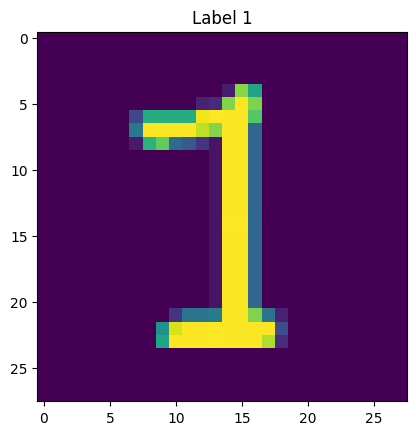

In [4]:
# Visualize an image from the dataset
for i, data in enumerate(train_loader):
    images, labels = data
    break
print('Shape of images from one batch : ', images.shape)
print('Shape of labels from one batch : ', labels.shape)

plt.imshow(images[0, 0])
plt.title('Label {}'.format(labels[0]));
plt.show()

Define the neural network.

In [5]:
# the CNN is defined here
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)  # 7*7 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Set whether to readout activation
        self.readout = False

    def forward(self, x):
        # Max pooling over a (2, 2) window
        l1 = F.max_pool2d(F.relu(self.conv1(x)), 2)
        l2 = F.max_pool2d(F.relu(self.conv2(l1)), 2)
        l2_flat = torch.flatten(l2, start_dim=1)  # flatten tensor, while keeping batch dimension
        l3 = F.relu(self.fc1(l2_flat))
        l4 = F.relu(self.fc2(l3))
        y = self.fc3(l4)
        
        if self.readout:
            return {'l1': l1, 'l2': l2, 'l3': l3, 'l4': l4, 'y': y} # names of the layers
        else:
            return y

Train the network on MNIST until it reaches 95% accuracy. It should take only ~500-1000 training steps.

In [6]:
# Instantiate the network and print information
net = Net()
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train for only one epoch
running_loss = 0
running_acc = 0
for i, data in enumerate(train_loader):
    image, label = data

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()    # Does the update

    # prediction
    prediction = torch.argmax(output, axis=-1)
    acc = torch.mean((label == prediction).float())

    running_loss += loss.item()
    running_acc += acc
    if i % 100 == 99:
        running_loss /= 100
        running_acc /= 100
        print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(
            i+1, running_loss, running_acc))
        if running_acc > 0.95:
            break
        running_loss, running_acc = 0, 0

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Step 100, Loss 0.9544, Acc 0.681
Step 200, Loss 0.3070, Acc 0.909
Step 300, Loss 0.2538, Acc 0.926
Step 400, Loss 0.2739, Acc 0.924
Step 500, Loss 0.2503, Acc 0.929
Step 600, Loss 0.2293, Acc 0.938
Step 700, Loss 0.2416, Acc 0.934
Step 800, Loss 0.2401, Acc 0.939
Step 900, Loss 0.2189, Acc 0.957


Visualize the activity of each layer of the trained network to an input digit from the test dataset.

Predicted label: 0


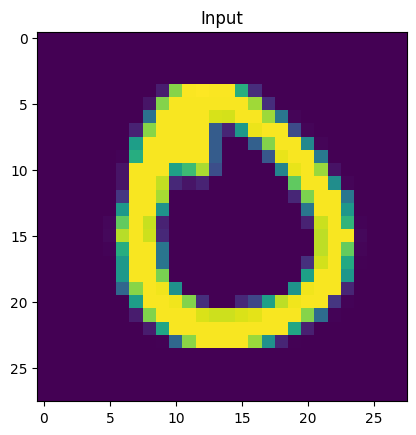

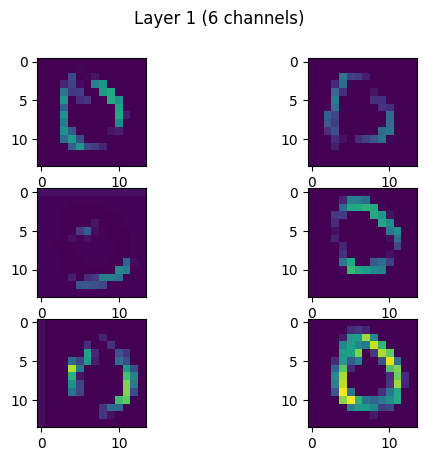

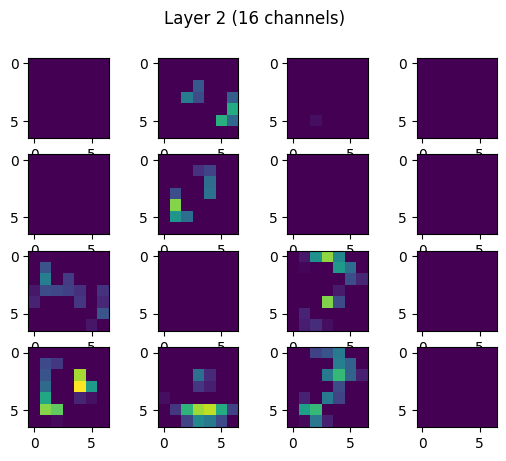

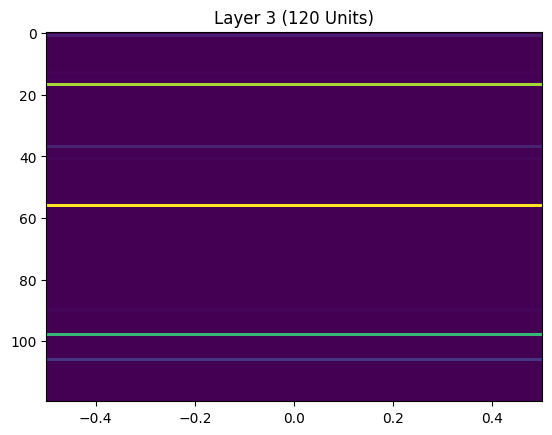

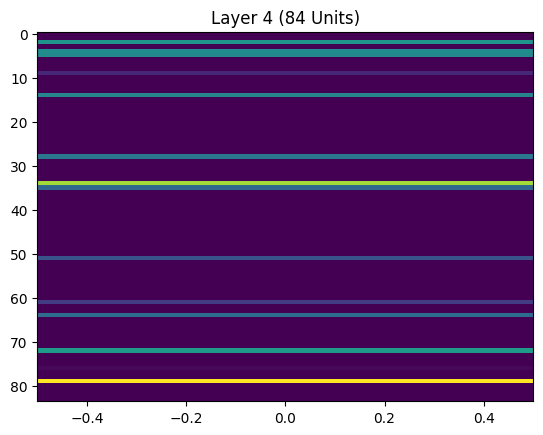

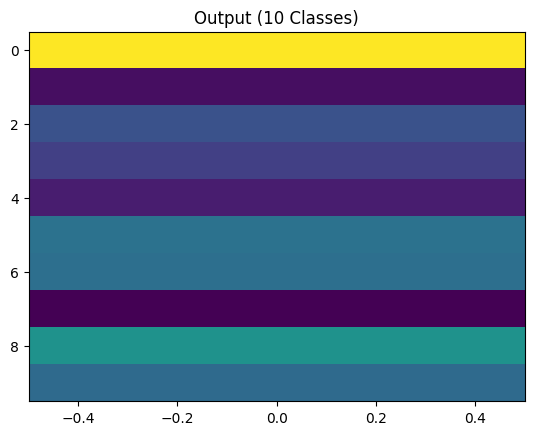

In [7]:
for i, data in enumerate(test_loader):
    images, labels = data
    break

# Readout network activity
net.readout = True
activity = net(images)

n_images = len(labels)
# transform the input and output data to numpy variables
ind = np.argsort(labels.numpy())
images = images.detach().numpy()[ind]
labels = labels.numpy()[ind]

# extract the activity of each layer
for key, val in activity.items():
    new_val = val.detach().numpy()[ind]
    activity[key] = new_val

# pick one image
i_image = 0

plt.imshow(images[i_image, 0]) # show the input
plt.title('Input');

layers = ['l1', 'l2', 'l3', 'l4', 'y'] # the layer names
layers_titles = ['Layer 1 (6 channels)','Layer 2 (16 channels)','Layer 3 (120 Units)','Layer 4 (84 Units)','Output (10 Classes)']

for layeri, layer in enumerate(layers):
    act = activity[layer]
    act = act[i_image]
    if len(act.shape) == 3:
        n_channels = act.shape[0]
        if n_channels == 6:
            n_x, n_y = 2, 3
        elif n_channels == 16:
            n_x, n_y = 4, 4
        else:
            n_x, n_y = n_channels, 1
        vmax = np.max(act)
        fig, axs = plt.subplots(n_y, n_x)
        fig.suptitle(layers_titles[layeri])
        for i_channel in range(n_channels):
            ax = axs[np.mod(i_channel, n_y), i_channel//n_y]
            ax.imshow(act[i_channel], vmin=0, vmax=vmax)
            #ax.set_axis_off()
        #plt.tight_layout()
    elif len(act.shape) == 1:
        fig = plt.figure()
        plt.imshow(act[:, np.newaxis], aspect='auto')
        plt.title(layers_titles[layeri])
        #plt.axis('off')
print('Predicted label:', labels[i_image])

#### Tuning analysis of specific neurons of the neural-network

Studying tuning properties of single neurons has been one of the most important analysis techniques in neuroscience. In neuroscience, it is interesting to know how certain stimuli can activate specific neurons. A tuning can be performed to investigate what the most optimal input stimulus is to fully activate a neuron (eg. an auditory stimulus with a specific frequency pattern that activates a specific neuron in the auditory cortex, a visual stimulus with a specific pattern that activates neurons in the visual cortex, etc.). Using this knowledge, these inputs can be used as building blocks to investigate more complex stimuli by decomposing it into its building blocks.

Similar to tuning methods of biological neurons, we will choose a neuron (node) from a layer of the trained CNN and find the preferred input image that most strongly activates this specific neuron (node) using gradient-based optimization. This can give us an idea of which patterns in an image are important to activate specific neurons (nodes) and therefore to decide on which number is visualized in the image. This method is particularly useful for studying neurons with complex tuning properties in higher layers.

In [8]:
# the gradient-based optimization function is defined here
def get_syn_image(layer,ind=[]):
    # Here syn_image is the variable to be optimized
    # Initialized randomly for search in parallel
    # the ind variable can be given to manually select the 
    # neuron index
    batch_size = 64
    image_size = [batch_size] + list(images.shape[1:])
    syn_image_init = np.random.rand(*image_size)
    syn_image = torch.tensor(syn_image_init, requires_grad=True, dtype=torch.float32)

    # Use Adam optimizer
    optimizer = optim.Adam([syn_image], lr=0.01)

    running_loss = 0
    running_loss_reg = 0
    for i in range(1000):
        optimizer.zero_grad()   # zero the gradient buffers
        syn_image.data.clamp_(min=0.0, max=1.0)
        syn_image_transform = (syn_image - 0.1307) / 0.3081
        activity = net(syn_image_transform)

        # Pick a neuron, and minimize its negative activity
        neuron = activity[layer]

        # Choose a neuron that is already most activated
        if i == 0 and not ind:
            neuron_avg = np.mean(neuron.detach().numpy(), axis=0)
            ind = np.argsort(neuron_avg.flatten())[-1]
            print('Chosen unit', ind) # the selected neuron

        neuron = neuron.view(batch_size, -1)[:, ind]
        if i == 0:
            print('Layer', layer)
            neuron_init = neuron.detach().numpy()

        loss = -torch.mean(torch.square(neuron))
        loss_reg = torch.mean(torch.square(syn_image_transform)) * 100
        loss += loss_reg
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_reg += loss_reg.item()
        if i % 100 == 99:
            running_loss /= 100
            running_loss_reg /= 100
            print('Step {}, Loss {:0.4f} Loss Regularization {:0.4f}'.format(
                i+1, running_loss, running_loss_reg))
            running_loss, running_loss_reg = 0, 0

    neuron = neuron.detach().numpy()
    syn_image = syn_image.detach().numpy()
    return syn_image, syn_image_init, neuron, ind

# run the optimization
layer = 'y' # the output layer is chosen
syn_image, syn_image_init, neuron, neuron_ind = get_syn_image(layer)

Chosen unit 8
Layer y
Step 100, Loss -248.0239 Loss Regularization 123.1631
Step 200, Loss -1275.3942 Loss Regularization 204.3434
Step 300, Loss -1564.1608 Loss Regularization 235.2273
Step 400, Loss -1676.7576 Loss Regularization 245.0482
Step 500, Loss -1726.6053 Loss Regularization 249.8669
Step 600, Loss -1753.7669 Loss Regularization 252.6787
Step 700, Loss -1768.7634 Loss Regularization 254.4366
Step 800, Loss -1776.3819 Loss Regularization 255.3949
Step 900, Loss -1782.2189 Loss Regularization 256.0740
Step 1000, Loss -1786.0474 Loss Regularization 256.5597


The above method takes a randomly selected input (syn_image_init) and optimizes it to maximize the activity of a specific neuron (neuron_ind) of the selected layer (layer). The result is the optimized input (syn_image) that most strongly activates the specific neuron of the selected layer. Visualize the input before and after the optimization procedure to see the effect that this procedure has on the stimulus. What can you tell about the optimized stimulus?

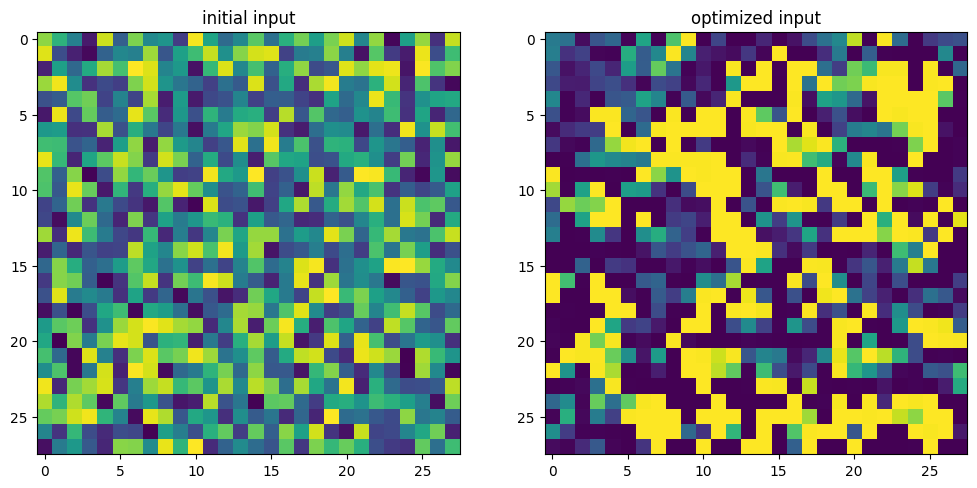

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(syn_image_init[0,0,:,:])
ax1.set_title('initial input')
ax2.imshow(syn_image[0,0,:,:])
ax2.set_title('optimized input')

plt.show()


<div class="alert alert-success">
<span style="color:black">

**Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
One can see that on the initial randomized input image the datapoints are random. Both the values and the spread of datapoints are incoherent. On the optimized image it is clear that the values are more grouped together. Low values stick toghether and higher values from clusters. There are also fewer average values in the optimized image. Here the values are more extream, either low or high. On the optimized image there is a hint that diagonal edges are favorable.

\end{tcolorbox}
     
</span>

Now give the two images (before and after the optimization) as inputs to the neural-network and visualize the outputs of the selected layer to these two inputs. For this, you can use the code of the previous section ("Visualize the activity of each layer of the trained network to an input digit from the test dataset") and plot only the output of the last layer. Can you tell from the plotted outputs of the layer which neuron was optimized? Do you notice a difference in the activity of the specific neuron after driving the neural-network with the optimized input?

Make sure that the inputs to the neural-network are of float32 type and 4-dimensional (B, 1, H, W), where B is the batch size (here 1) and H, W are the height and width dimensions of the image. To facilitate a better comparison, it is better to use the same colorscale for both inputs and outputs (by setting one common vmax limit for imshow). 

In [10]:
image = torch.tensor(syn_image_init[0].reshape(1,1,28,28), requires_grad=True, dtype=torch.float32)
image.shape

torch.Size([1, 1, 28, 28])

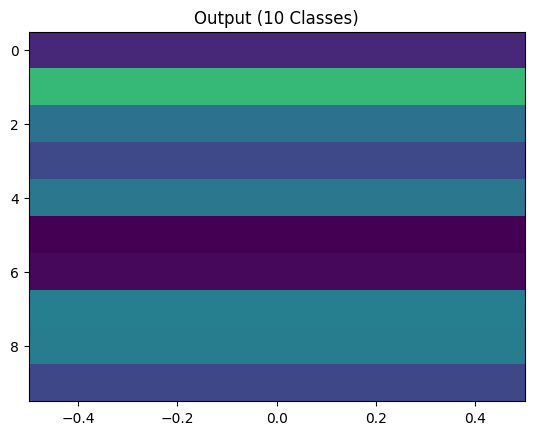

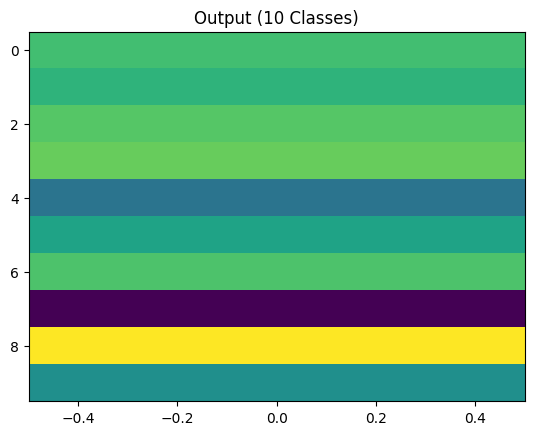

In [11]:
# Readout network activity
net.readout = True
image_init = torch.tensor(syn_image_init[0].reshape(1,1,28,28), requires_grad=True, dtype=torch.float32)
image_opt = torch.tensor(syn_image[0].reshape(1,1,28,28), requires_grad=True, dtype=torch.float32)
images = [image_init, image_opt]

for image in images:
    activity = net(image)

    layers = ['y'] # the layer names
    layers_titles = ['Output (10 Classes)']

    for layeri, layer in enumerate(layers):
        act = activity[layer]
        act = act[i_image]
        if len(act.shape) == 3:
            n_channels = act.shape[0]
            if n_channels == 6:
                n_x, n_y = 2, 3
            elif n_channels == 16:
                n_x, n_y = 4, 4
            else:
                n_x, n_y = n_channels, 1
            vmax = np.max(act)
            fig, axs = plt.subplots(n_y, n_x)
            fig.suptitle(layers_titles[layeri])
            for i_channel in range(n_channels):
                ax = axs[np.mod(i_channel, n_y), i_channel//n_y]
                ax.imshow(act[i_channel], vmin=0, vmax=vmax)
                #ax.set_axis_off()
            #plt.tight_layout()
        elif len(act.shape) == 1:
            act = act.detach().numpy()
            fig = plt.figure()
            plt.imshow(act[:, np.newaxis], aspect='auto', vmax=1)
            plt.title(layers_titles[layeri])
            #plt.axis('off')

<div class="alert alert-success">
<span style="color:black">

**Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
The random image has low prediction values for all digits. The optimized image has a clear preference to one single output neuron (in this simulation didgit 8).

\end{tcolorbox}
     
</span>

Perform the same tuning analysis for a neuron of a convolutional layer of the neural-network. What differences do you see in the image that the optimization method gives for a convolutional layer, when compared to the one you got for the output (dense) layer of the neural network?

Chosen unit 386
Layer l2
Step 100, Loss 52.8134 Loss Regularization 61.3925
Step 200, Loss -8.1630 Loss Regularization 11.2176
Step 300, Loss -9.1513 Loss Regularization 11.7718
Step 400, Loss -9.2015 Loss Regularization 11.8430
Step 500, Loss -9.2025 Loss Regularization 11.8445
Step 600, Loss -9.2029 Loss Regularization 11.8447
Step 700, Loss -9.2030 Loss Regularization 11.8445
Step 800, Loss -9.2026 Loss Regularization 11.8444
Step 900, Loss -9.2025 Loss Regularization 11.8450
Step 1000, Loss -9.2029 Loss Regularization 11.8446


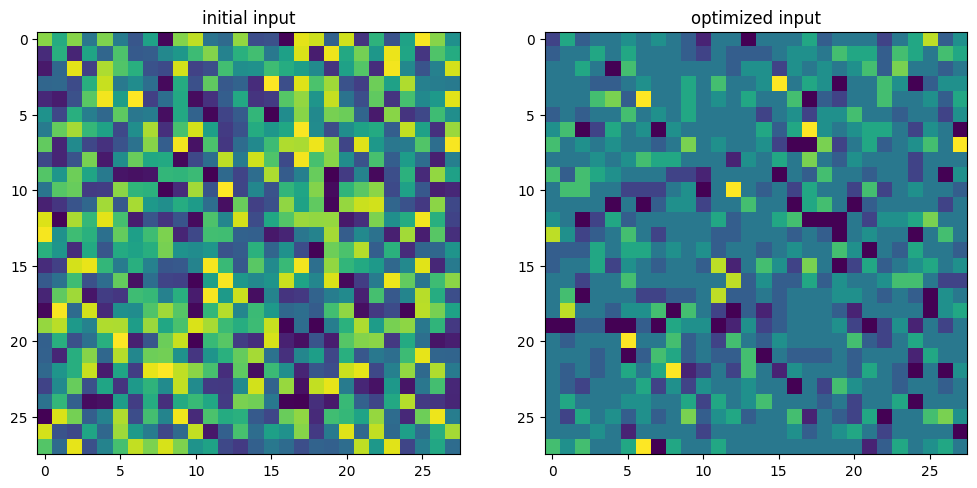

In [13]:
for i, data in enumerate(test_loader):
    images, labels = data
    break

# Readout network activity
net.readout = True
activity = net(images)

n_images = len(labels)
# transform the input and output data to numpy variables
ind = np.argsort(labels.numpy())
images = images.detach().numpy()[ind]
labels = labels.numpy()[ind]

layer = 'l2' # the second layer is chosen
syn_image, syn_image_init, neuron, neuron_ind = get_syn_image(layer)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(syn_image_init[0,0,:,:])
ax1.set_title('initial input')
ax2.imshow(syn_image[0,0,:,:])
ax2.set_title('optimized input')

plt.show()

<div class="alert alert-success">
<span style="color:black">

**Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
In this case it is more dificult to understand what is exactily going on since we select a layer deeper inside the network. We do observe however that in the selected neuron of the convolutional layer the overall activity is much lower. Mostly clusters of low activity values are present.
\end{tcolorbox}
     
</span>

### 2. Predicting cognitive tasks with neural-networks

#### Training an LSTM to perform a simple memory task
An input stream of numbers (from -1 to 1) is sequentially presented at fixed time intervals (e.g. every 1 ms). The task is to keep in memory the presented number when the "memorize" stimulus is given and report back the memorized value when the "report" stimulus is given. The "memorize" and "report" signals can be given at any time point inside the selected sequence length (seq_len), which corresponds to the memory duration needed to perform the task. This will demonstrate how you can implement a neural network with a temporal memory.

In [14]:
# the memory task is defined here
def memory_task(seq_len, batch_size, n_repeat=1):
    """Return a batch from a simple memory task."""
    # seq_len defines the sequence length of the task and n_repeat the number of sequences  
    inputs = np.zeros((seq_len * n_repeat, batch_size, 3))
    outputs = np.zeros((seq_len * n_repeat, batch_size, 1))

    for i in range(n_repeat):
        t_start = i * seq_len
        inputs[t_start:t_start+seq_len, :, 0] = np.random.uniform(-1, 1, size=(seq_len, batch_size))
        t_stim = np.random.randint(int(seq_len)/2, size=(batch_size,))
        t_test = np.random.randint(int(seq_len)/2, seq_len-1, size=(batch_size,))
        inputs[t_start + t_stim, range(batch_size), 1] = 1
        inputs[t_start + t_test, range(batch_size), 2] = 1

        outputs[t_start + t_test, range(batch_size), 0] = inputs[t_start + t_stim, range(batch_size), 0]
    
    return inputs, outputs

# generate the input and output datasets providing the desired parameters of the memory task
inputs, outputs = memory_task(seq_len=100, batch_size=32, n_repeat=3)

Show an example case of the task for a sample trial.

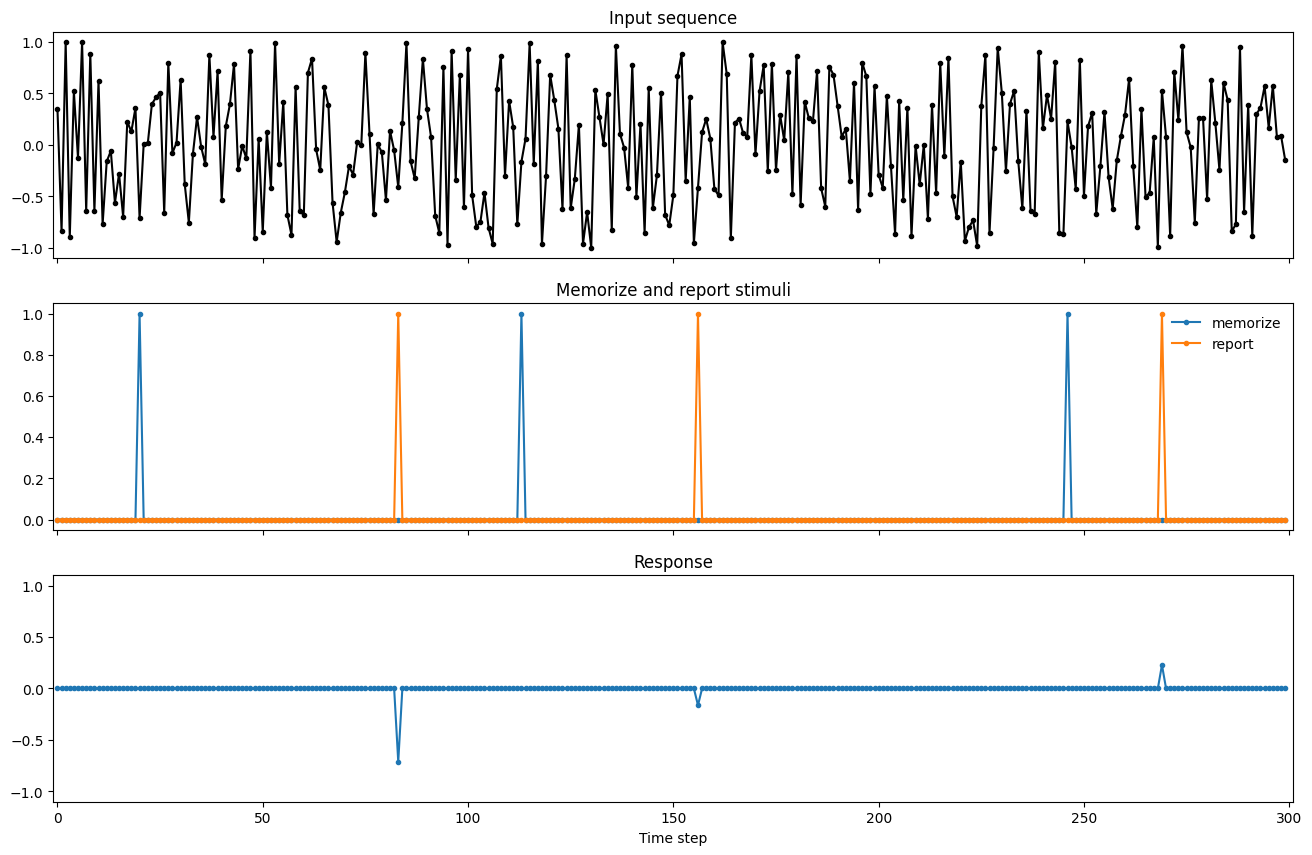

In [15]:
# pick a trial to visualize
i_trial = 0

kwargs = {'marker': 'o', 'markersize': 3}
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(16,10))
ax = axes[0]
ax.plot(inputs[:, i_trial, 0], label='stimulus', color='black', **kwargs)
ax.title.set_text('Input sequence')
ax.set_ylim(-1.1,1.1);ax.set_xlim(-1,301)
ax = axes[1]
ax.plot(inputs[:, i_trial, 1], label='memorize', **kwargs)
ax.plot(inputs[:, i_trial, 2], label='report', **kwargs)
ax.title.set_text('Memorize and report stimuli')
ax.legend(frameon=False)
ax = axes[2]
ax.plot(outputs[:, i_trial, 0], label='target', **kwargs)
ax.title.set_text('Response')
ax.set_xlabel('Time step')
ax.set_ylim(-1.1,1.1);

We define an one-unit LSTM network that will be trained to perform this task. A custom LSTM implementation in raw pytorch is used to provide access to the neural-network's gating variables.

In [16]:
# the LSTM is defined here
class MyLSTM(nn.Module):
    """Manual implementation of LSTM."""

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, 4*hidden_size)
        self.h2h = nn.Linear(hidden_size, 4*hidden_size)
        
        self.readout = False  # whether to readout activity

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        
        hx, cx = hidden
        gates = self.input2h(input) + self.h2h(hx)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, dim=1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)
        
        if self.readout:
            result = {
                'ingate': ingate,
                'outgate': outgate,
                'forgetgate': forgetgate,
                'input': cellgate,
                'cell': cy,
                'output': hy,
            }
            return (hy, cy), result
        else:
            return hy, cy

    def forward(self, input, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(input)

        if not self.readout:
            # Regular forward
            output = []
            for i in range(input.size(0)):
                hidden = self.recurrence(input[i], hidden)
                output.append(hidden[0])

            output = torch.stack(output, dim=0)
            return output, hidden

        else:
            output = []
            result = defaultdict(list)  # dictionary with default as a list
            for i in range(input.size(0)):
                hidden, res = self.recurrence(input[i], hidden)
                output.append(hidden[0])
                for key, val in res.items():
                    result[key].append(val)

            output = torch.stack(output, dim=0)
            for key, val in result.items():
                result[key] = torch.stack(val, dim=0)

            return output, hidden, result

class Net(nn.Module):
    """Recurrent network model."""
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # self.rnn = nn.LSTM(input_size, hidden_size, **kwargs)
        self.rnn = MyLSTM(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

Train the network until it reaches a loss close to 0 (<1e-4). Sometimes the training takes some time to reach the desired loss, you can wait or otherwise restart the training.

In [17]:
# Using custom LSTM, ~30% slower on CPUs compare to native LSTM
net = Net(input_size=3, hidden_size=1, output_size=1)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

running_loss = 0
start_time = time.time()

print_step = 5000
for i in range(20000):
    seq_len = np.random.randint(5, 20)  # Help learning and generalization
    inputs, labels = memory_task(seq_len=seq_len, batch_size=16, n_repeat=3)
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels).type(torch.float)

    optimizer.zero_grad()   # zero the gradient buffers
    output, activity = net(inputs)

    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        running_loss /= print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
#         print('Time per step {:0.3f}ms'.format((time.time()-start_time)/i*1e3))
        if running_loss < 1e-4:
            break
        running_loss = 0

Step 5000, Loss 0.0355
Step 10000, Loss 0.0327
Step 15000, Loss 0.0122
Step 20000, Loss 0.0000


Visualize the predicted performance of the trained LSTM model for a sequence length (memory duration) of 20 ms.

In [18]:
# initialize the RNN network
rnn = net.rnn
rnn.readout = True

# generate the inputs and target outputs of the desired memory task
inputs, labels = memory_task(seq_len=20, batch_size=16, n_repeat=2)
inputs = torch.from_numpy(inputs).type(torch.float)

# simulate the predicted output of the LSTM network to the generated set of inputs
with torch.no_grad():
    rnn_activity, _, result = rnn(inputs)
    output = net.fc(rnn_activity).detach()

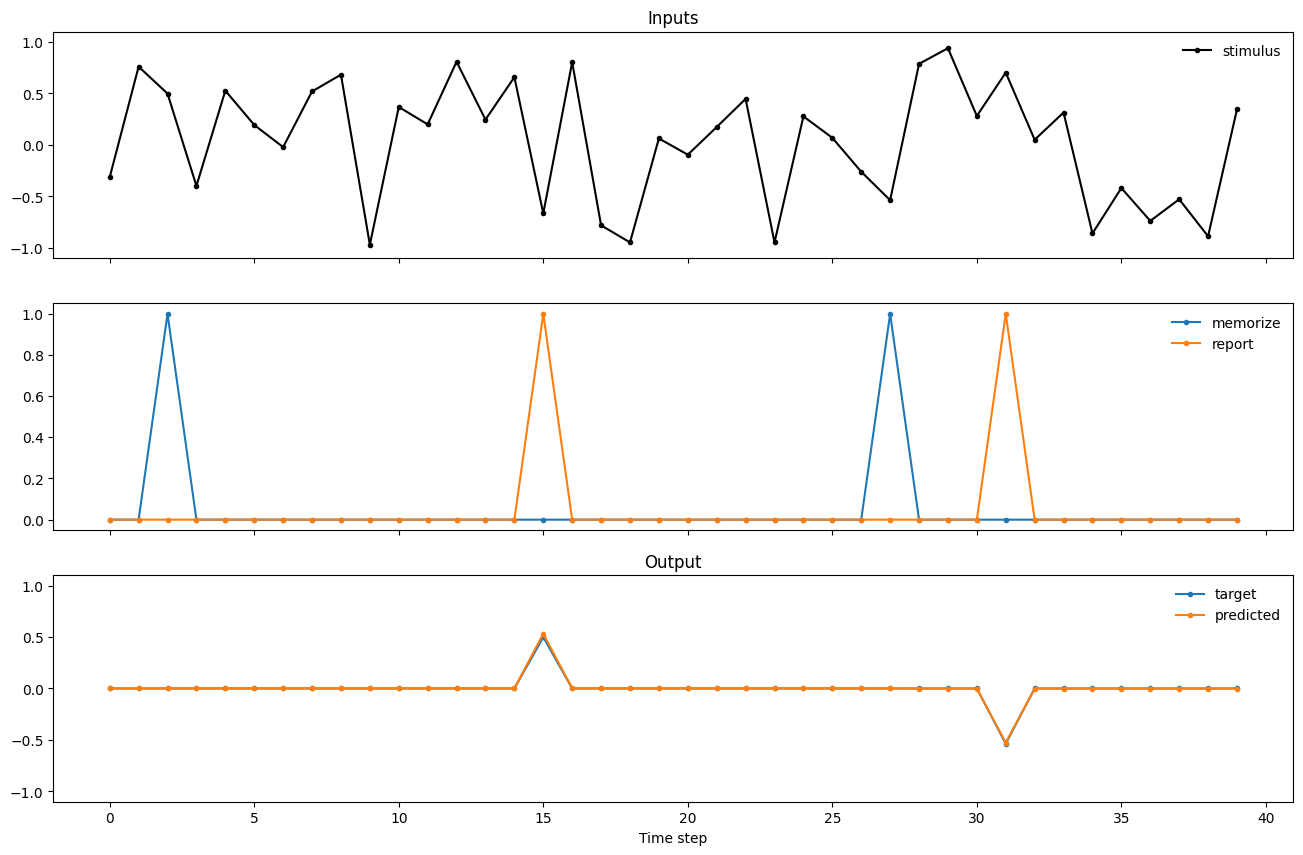

In [19]:
# pick a trial to visualize
i_trial = 0

kwargs = {'marker': 'o', 'markersize': 3}
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(16,10))
ax = axes[0]
ax.plot(inputs[:, i_trial, 0], label='stimulus', color='black', **kwargs)
ax.legend(frameon=False)
ax.title.set_text('Inputs')
ax.set_ylim(-1.1,1.1);
ax = axes[1]
ax.plot(inputs[:, i_trial, 1], label='memorize', **kwargs)
ax.plot(inputs[:, i_trial, 2], label='report', **kwargs)
ax.legend(frameon=False)
ax = axes[2]
ax.plot(labels[:, i_trial, 0], label='target', **kwargs)
ax.plot(output[:, i_trial, 0], label='predicted', **kwargs)
ax.title.set_text('Output')
ax.set_xlabel('Time step')
ax.legend(frameon=False)
ax.set_ylim(-1.1,1.1);

Depending on how successful the training was, you will see that the LSTM can perform the task almost perfectly for short memory durations (20 ms). The last panel of the plot (Output) shows the expected response of the memory task (target) and the one generated by the trained LSTM (predicted).

You can now use the trained LSTM to simulate the outcomes of the task for longer sequence durations. After which point approximately do you see that the network loses accuracy, failing to report the correct numbers? What would you change in the training datasets or the architecture to improve the model so that it performs better for longer memory durations in this task?

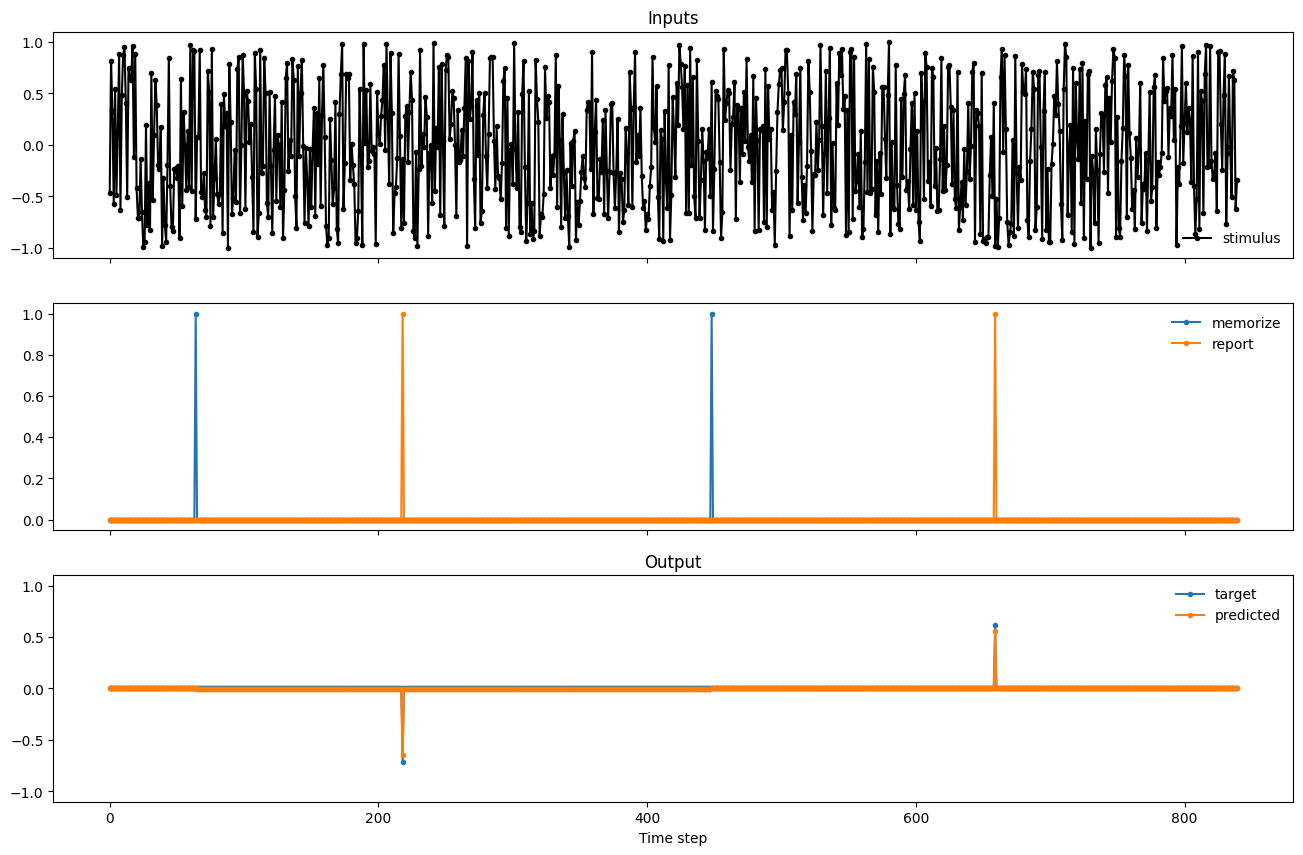

In [28]:
# initialize the RNN network
rnn = net.rnn
rnn.readout = True

# generate the inputs and target outputs of the desired memory task
inputs, labels = memory_task(seq_len=420, batch_size=16, n_repeat=2)
inputs = torch.from_numpy(inputs).type(torch.float)

# simulate the predicted output of the LSTM network to the generated set of inputs
with torch.no_grad():
    rnn_activity, _, result = rnn(inputs)
    output = net.fc(rnn_activity).detach()

# pick a trial to visualize
i_trial = 0

kwargs = {'marker': 'o', 'markersize': 3}
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(16,10))
ax = axes[0]
ax.plot(inputs[:, i_trial, 0], label='stimulus', color='black', **kwargs)
ax.legend(frameon=False)
ax.title.set_text('Inputs')
ax.set_ylim(-1.1,1.1);
ax = axes[1]
ax.plot(inputs[:, i_trial, 1], label='memorize', **kwargs)
ax.plot(inputs[:, i_trial, 2], label='report', **kwargs)
ax.legend(frameon=False)
ax = axes[2]
ax.plot(labels[:, i_trial, 0], label='target', **kwargs)
ax.plot(output[:, i_trial, 0], label='predicted', **kwargs)
ax.title.set_text('Output')
ax.set_xlabel('Time step')
ax.legend(frameon=False)
ax.set_ylim(-1.1,1.1);

<div class="alert alert-success">
<span style="color:black">

**Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
The network starts to fail starting from around 420 ms. The one-unit LSTM network may struggle to model longer input sequences if it is trained on shorter sequences because the network's internal memory is limited, and it may not be able to capture long-term dependencies and patterns in the data. 

To improve the model one could include longer signals to the training set. Changing the network architecture by adding more LSTM cells or stacking multiple LSTM layers can increase the network's memory capacity and allow it to better capture long-term dependencies in the data.

\end{tcolorbox}
     
</span>

#### Gating in neural-networks

The LSTM we used consists of three types of gating variables that control the cell state of the neural-network. When trained on this specific memory task, can you explain what the specific role of each gating variable is and how each one affects the cell state (memory) of the neural network? Visualizing the gate values of the three variables over the time course of the task (extracted from the "result" dictionary variable) can help you with that.

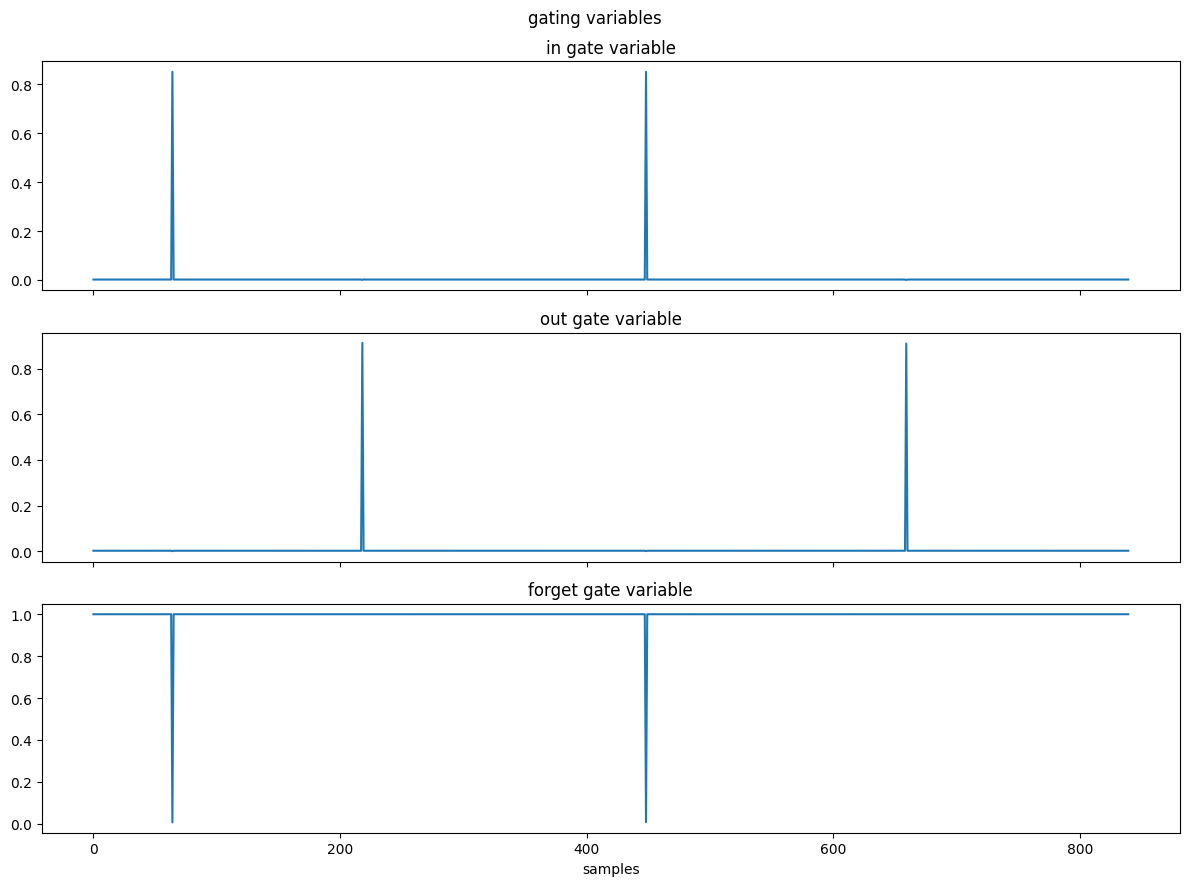

In [51]:
_,_, results = rnn.forward(inputs)
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,9),sharex=True)
ax1.plot(results['ingate'].detach().numpy()[:,0,0])
ax2.plot(results['outgate'].detach().numpy()[:,0,0])
ax3.plot(results['forgetgate'].detach().numpy()[:,0,0])

ax1.set_title('in gate variable')
ax2.set_title('out gate variable')
ax3.set_title('forget gate variable')
ax3.set_xlabel('samples')
plt.suptitle('gating variables')
plt.tight_layout()
plt.show()

<div class="alert alert-success">
<span style="color:black">

**Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
The three types of gating variables in an LSTM network are the input gate, the forget gate, and the output gate. Each gating variable controls the flow of information in and out of the LSTM cell, allowing the network to selectively retain or forget information over time.

Input gate: The input gate determines which parts of the current input should be added to the cell state. It takes the current input and the previous hidden state as input and applies a sigmoid activation function to both of them. The output of the sigmoid is then multiplied with a candidate activation vector, which is passed through a tanh activation function to produce the new cell state. This gate allows the LSTM to selectively add new information to the cell state based on the current input and the previous hidden state.

Forget gate: The forget gate determines which parts of the previous cell state should be retained or forgotten. It takes the previous hidden state and the previous cell state as input and applies a sigmoid activation function to both of them. The output of the sigmoid is then multiplied with the previous cell state to produce the new cell state. This gate allows the LSTM to selectively forget information that is no longer relevant based on the previous hidden state.

Output gate: The output gate determines which parts of the cell state should be output as the final hidden state. It takes the current input and the previous hidden state as input and applies a sigmoid activation function to both of them. The output of the sigmoid is then multiplied with the current cell state, which is passed through a tanh activation function to produce the new hidden state. This gate allows the LSTM to selectively output relevant information from the cell state based on the current input and the previous hidden state.

\end{tcolorbox}
     
</span>

How does gating in LSTMs compare to gating in biological neural circuits?

<div class="alert alert-success">
<span style="color:black">

**Answer** 
    
\begin{tcolorbox}[colback=green!5]
    
In biological neural circuits, gating is achieved through the opening and closing of ion channels in the cell membrane, which allows or blocks the flow of ions across the membrane. Similarly, in LSTMs, gating is achieved through the use of sigmoid activation functions that act as gates, allowing or blocking the flow of information in and out of the LSTM cell.  Both use a gating mechanism to selectively control the flow of information, allowing the system to retain and use relevant information while discarding irrelevant information.

\end{tcolorbox}
     
</span>